In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

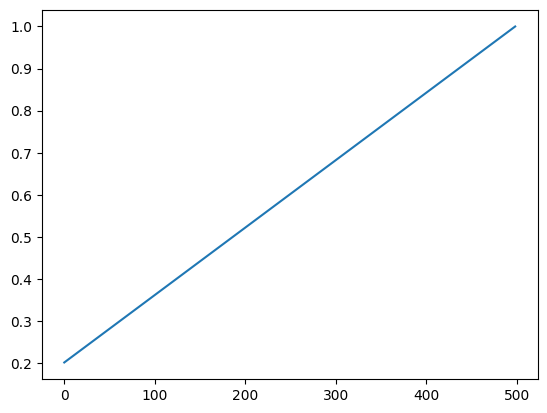

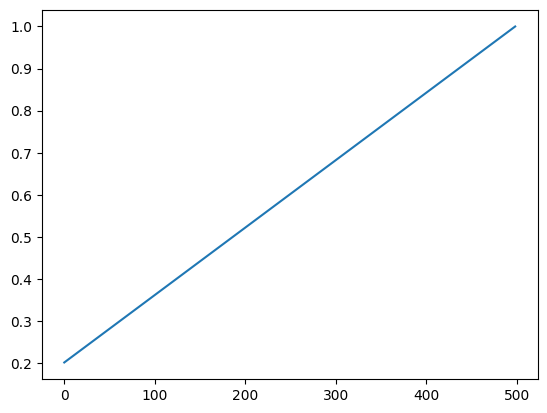

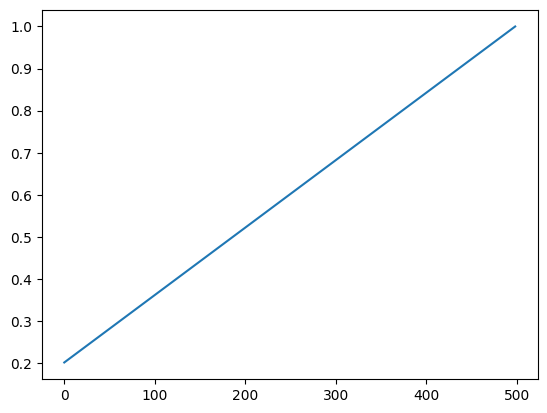

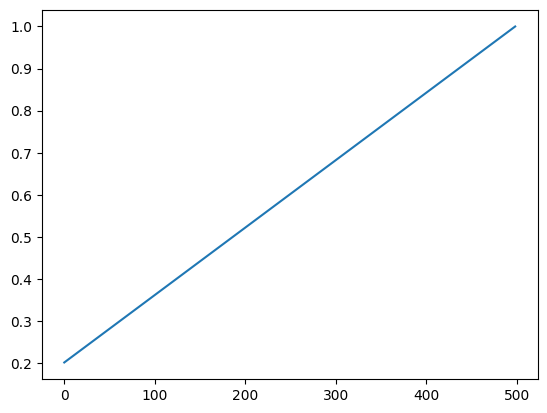

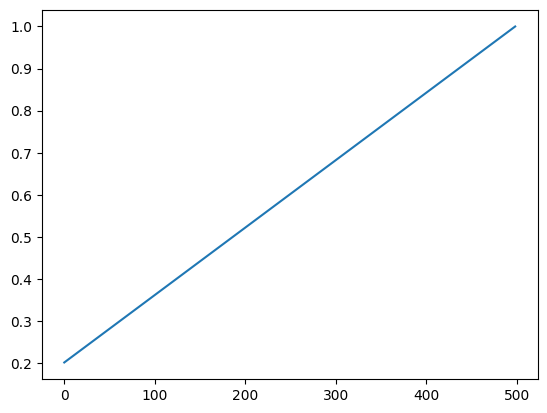

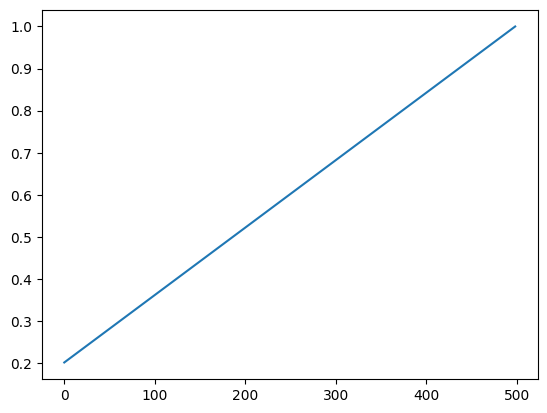

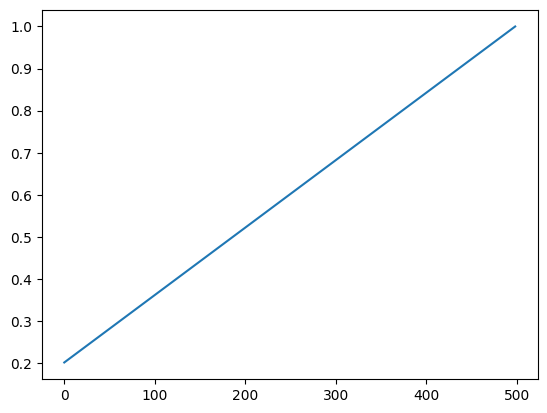

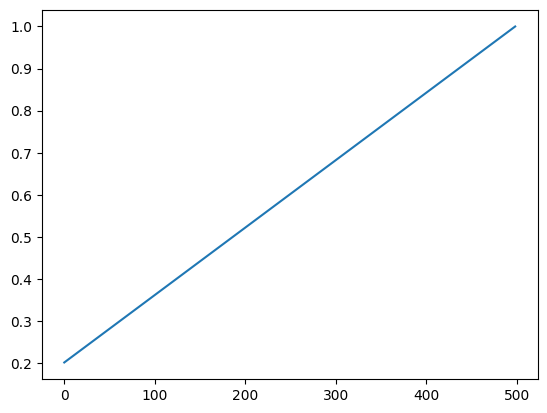

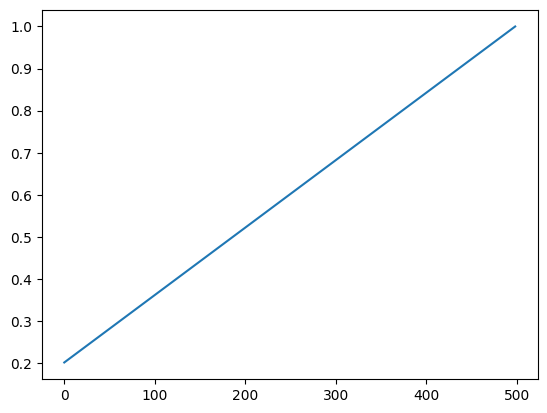

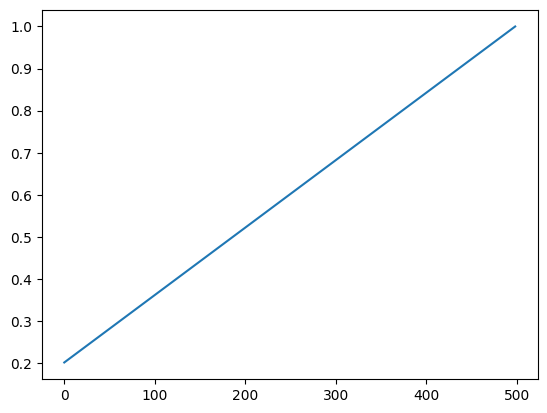

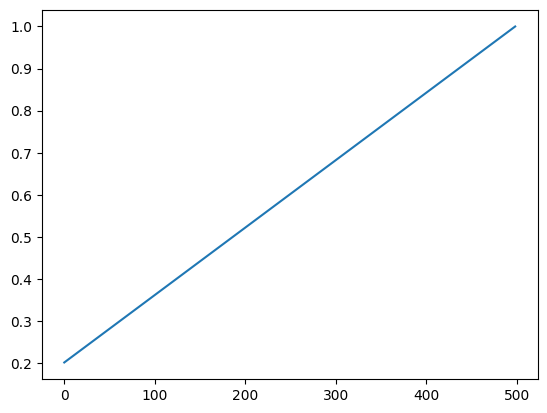

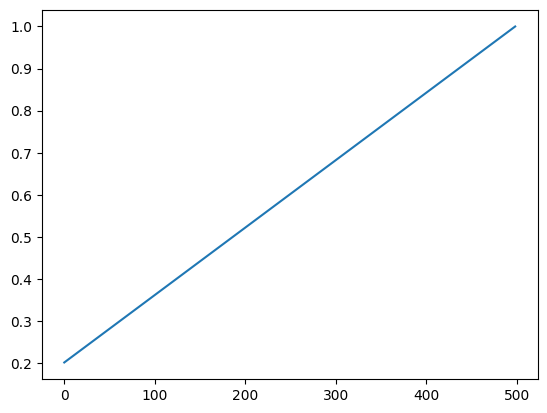

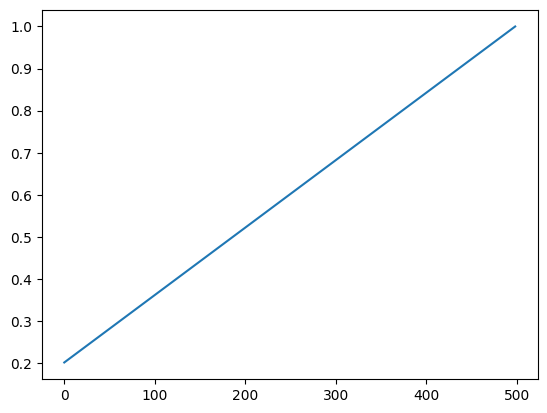

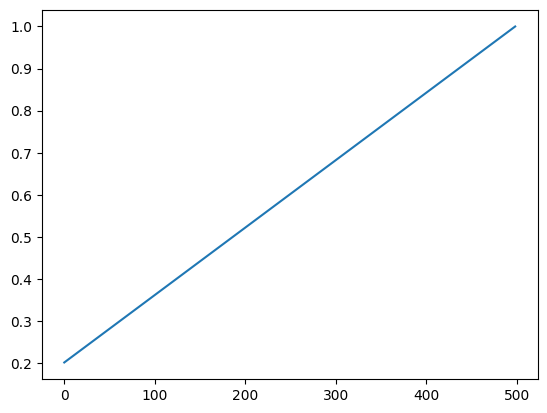

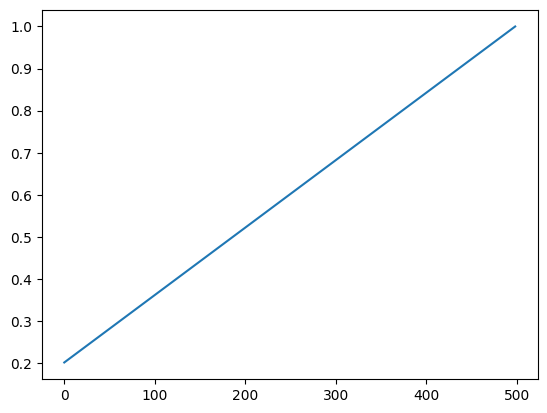

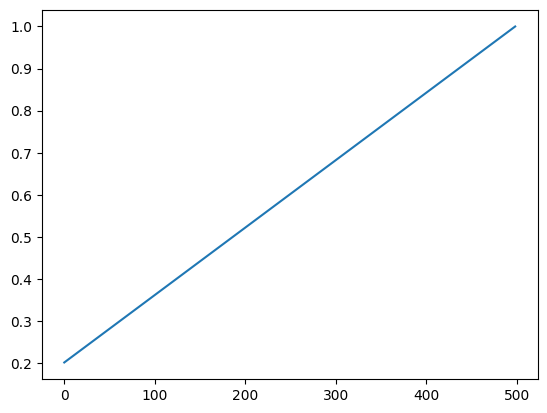

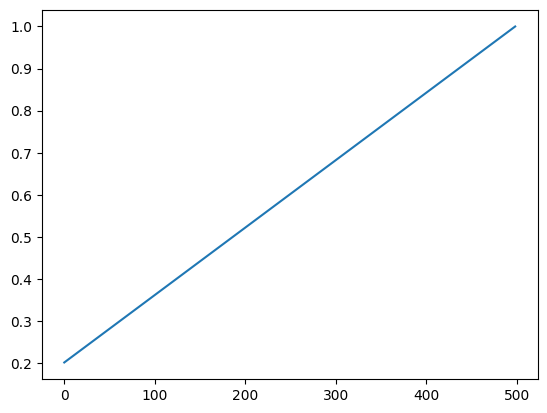

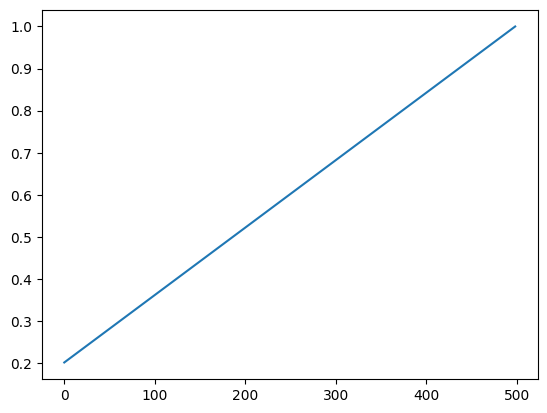

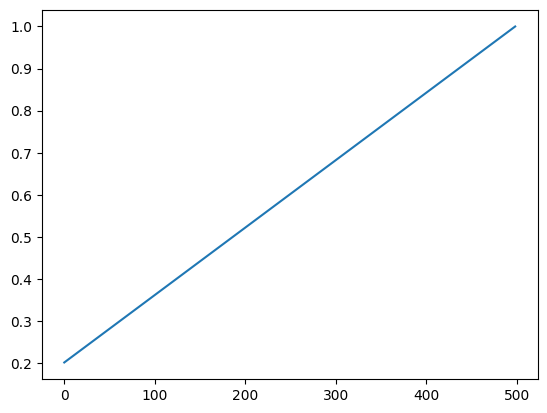

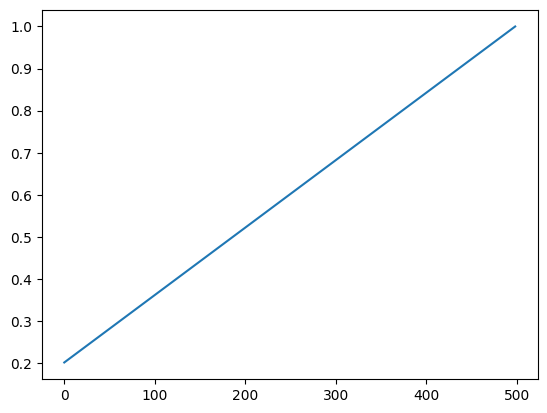

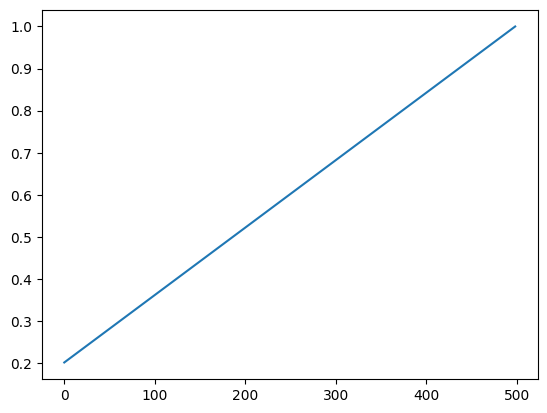

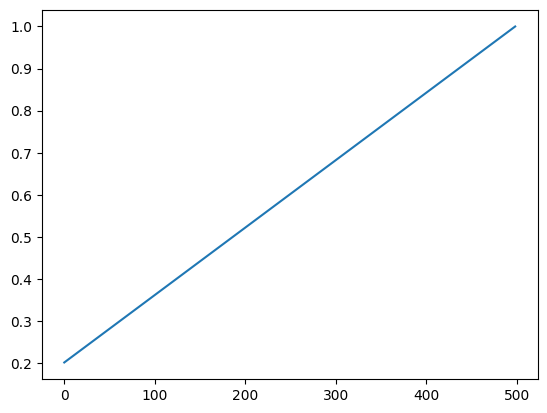

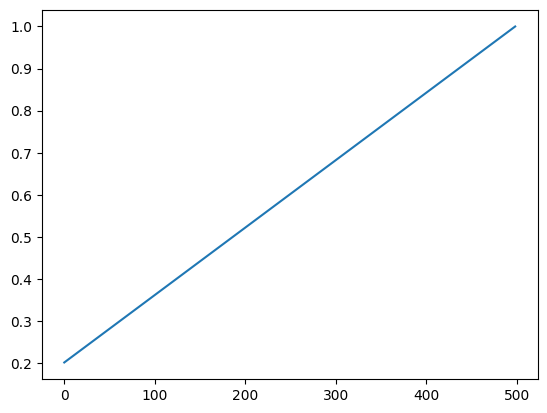

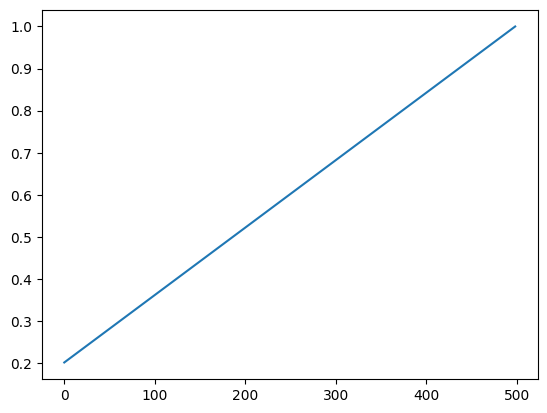

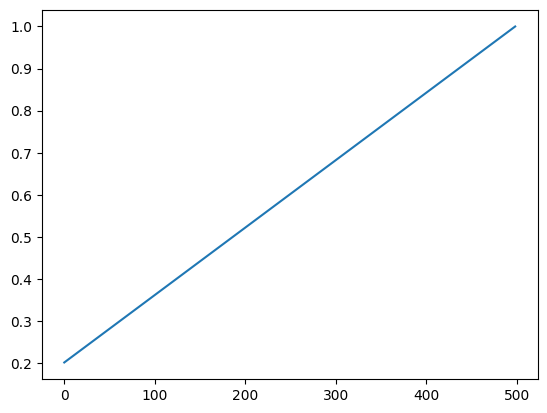

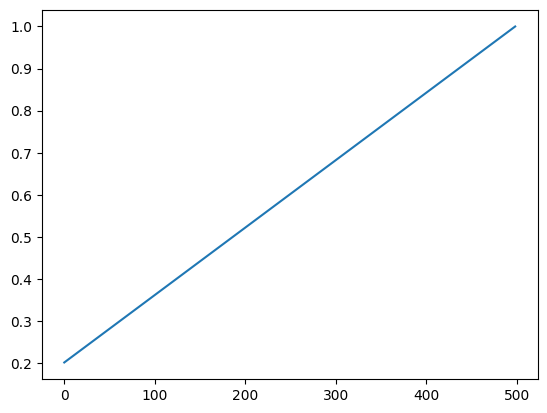

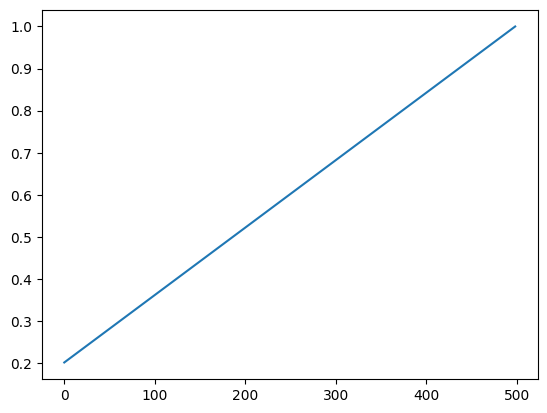

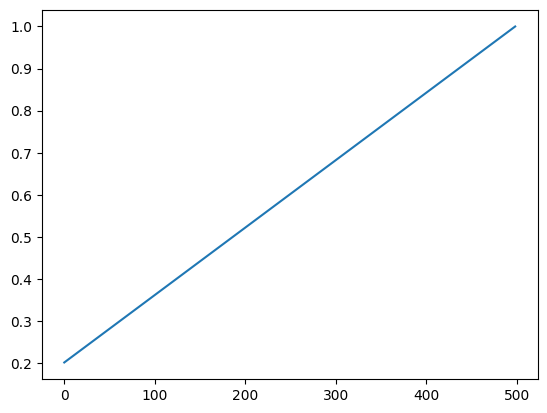

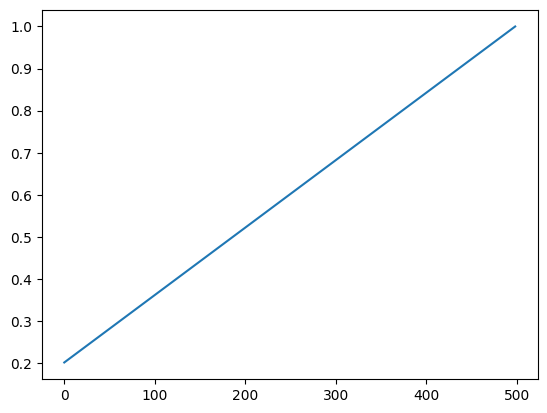

In [24]:
# Load the without EDM data in

for i in range(29):
    filename=f"data/Without EDM/G2_{i:02}.pkl"
    with open(filename, "rb") as f:
        data = pickle.load(f)
        angle = data[0][0][0]
        probs = data[0][0][1:]

        plt.plot(probs)
        plt.show()
    